# Практическое задание №4 "Алгоритм построения дерева решений".

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)
2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [1]:
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection

import matplotlib.pyplot as plt
%matplotlib inline

## Задание №1

__Методы и классы:__

In [2]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [3]:
# Реализуем класс листа
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data # значения признаков
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его   
        prediction = max(classes, key=classes.get)
        return prediction

In [4]:
# Расчет критерия Джини, критерий информативности
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels) # долю объектов класса в листе
        impurity -= p ** 2 # Критерий Джини
        
    return impurity

In [5]:
# Расчет качества
def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0]) # для правого (1-p)
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels) # Функционал качества

In [6]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    # index - индекс признака в data
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [7]:
# Нахождение наилучшего разбиения (для всего лишь 1 узла, происходит обход всех признаков)
def find_best_split(data, labels, min_leaf=1):
    current_gini = gini(labels) 

    best_quality = 0
    best_t = None # лучший порог разбиения
    best_index = None # лучший индекс разбиения
    
    n_features = data.shape[1] # кол-во признаков
    
    for index in range(n_features): # проход по всем признакам
        t_values = [row[index] for row in data] # берем столбец/признак с соотв. индексом
        
        for t in t_values: # проход по признаку
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t) # делаем разбиение
            
            #  пропускаем разбиения, в которых в узле остается объектов менее чем min_leaf
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue # начинаем следующий проход цикла, минуя оставшееся тело цикла
            
            # расчет качества текущего разбиения
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

Добавление новых критериев останова:

* Зануление качества
* Ограничение по глубине дерева
* Минимальное количество объектов в узле/листе.

In [8]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, depth=None, min_leaf=1):
    
    n_obj = data.shape[0]
    
    # корень
    quality, t, index = find_best_split(data, labels, min_leaf) # ищем лучшее разбиение

    # Критерий останова: нет прироста качества или глубина дерева или минимальное количество объектов в узле 
    if (quality == 0) or (depth == 0) or (n_obj <= min_leaf): # критерий останова
        return Leaf(data, labels) # считаем прогноз для листьев

    # если качество улучшилось, то делим дерево по лучшему разбиению
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева (ветки)
    if depth is not None:
        depth -=1
    true_branch = build_tree(true_data, true_labels, depth, min_leaf)
    false_branch = build_tree(false_data, false_labels, depth, min_leaf)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [9]:
# Проход объекта (объект=набор признаков одного объекта) по дереву для его классификации
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): # проверка текущий узел это лист?
        answer = node.prediction # считаем прогноз для листа
        return answer

    if obj[node.index] <= node.t: # если значение признака меньше порога t
        return classify_object(obj, node.true_branch) # рекурсия: отправляем объект в true-ветку
    else:
        return classify_object(obj, node.false_branch) # рекурсия: отправляем объект в false-ветку

In [10]:
# Предсказание деревом для всего датасета
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree) # определяем ветки для объектов
        classes.append(prediction)
    return classes

In [11]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

__Генерация выборки, построение модели, оценка качества модели:__

In [12]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=1500, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, n_clusters_per_class=1, random_state=5)

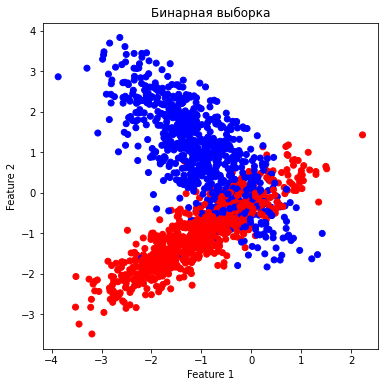

In [13]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Бинарная выборка')
plt.show()

In [14]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

* Модель с параметрами: min_leaf=5 (как в вебинаре)

In [15]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, min_leaf=5)
# Расчет предсказаний для тренировочной и тестовой выборки
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)
# Точность на обучающей и тестовой выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, answers)
train_accuracy, test_accuracy

(94.0952380952381, 88.44444444444444)

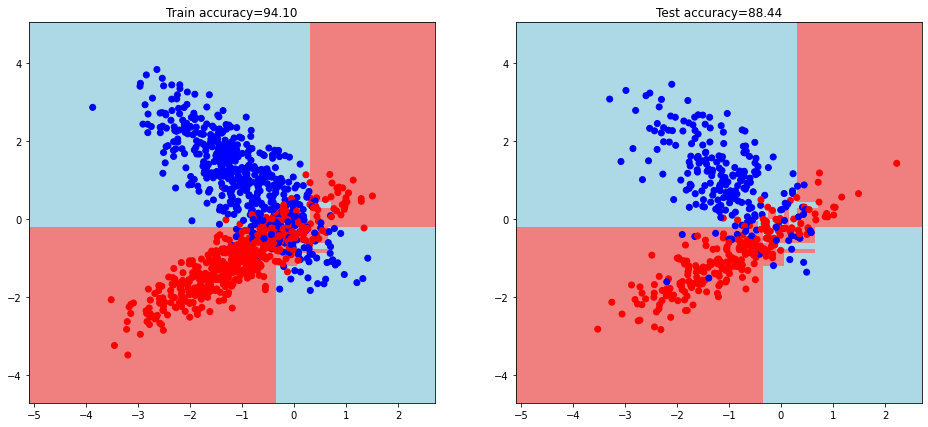

In [16]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

Как видим модель сильно переобучилась, попробуем добавить ограничение на глубину.

* Модель с параметрами: depth=5, min_leaf=5

In [17]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, depth=5, min_leaf=5)
# Расчет предсказаний для тренировочной и тестовой выборки
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)
# Точность на обучающей и тестовой выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, answers)
train_accuracy, test_accuracy

(91.61904761904762, 89.33333333333333)

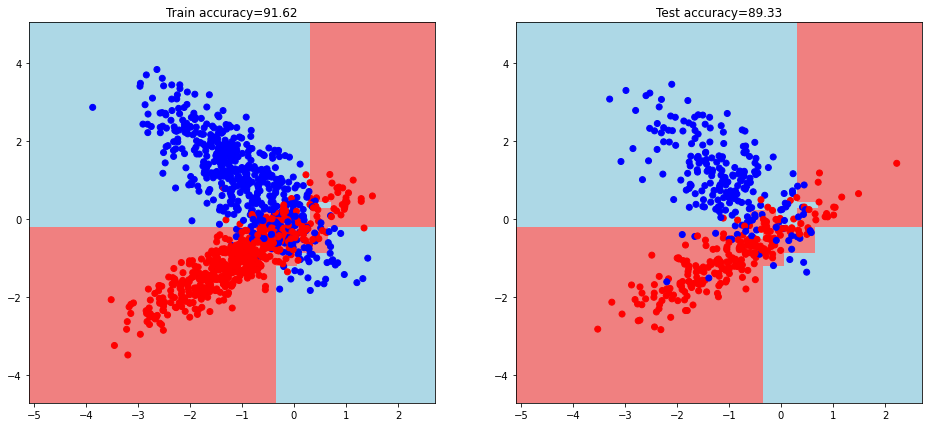

In [18]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

Изменяя гиперпараметры можно подбором определить оптимальные:

In [19]:
np.set_printoptions(precision=3)
depth_list = [3,5,10]
min_leaf_list = [5,10]

for d in depth_list:
    for m_l in min_leaf_list:
        my_tree = build_tree(train_data, train_labels, depth=d, min_leaf=m_l)
        train_answers = predict(train_data, my_tree)
        answers = predict(test_data, my_tree)
        train_accuracy = accuracy_metric(train_labels, train_answers)
        test_accuracy = accuracy_metric(test_labels, answers)
        print(f"Model: depth={d}, min_leaf={m_l}")
        print(f"\tTrain_acc: {train_accuracy}, Test_acc: {test_accuracy}, delta: {np.abs(train_accuracy-test_accuracy)}")
        train_accuracy, test_accuracy
    print("")

Model: depth=3, min_leaf=5
	Train_acc: 90.28571428571428, Test_acc: 88.88888888888889, delta: 1.3968253968253919
Model: depth=3, min_leaf=10
	Train_acc: 90.28571428571428, Test_acc: 88.88888888888889, delta: 1.3968253968253919

Model: depth=5, min_leaf=5
	Train_acc: 91.61904761904762, Test_acc: 89.33333333333333, delta: 2.285714285714292
Model: depth=5, min_leaf=10
	Train_acc: 91.42857142857143, Test_acc: 88.0, delta: 3.4285714285714306

Model: depth=10, min_leaf=5
	Train_acc: 94.0, Test_acc: 88.88888888888889, delta: 5.111111111111114
Model: depth=10, min_leaf=10
	Train_acc: 92.0952380952381, Test_acc: 86.8888888888889, delta: 5.206349206349202



Если выборка большая, то обучение происходит очень долго. Связано это с тем, что при разбиении мы анализируем каждый признак.

## Задание №2

__Изменим некоторые классы и методы из задания 1, создадим дисперсионный критерий информативности:__

In [20]:
# Реализуем класс листа. Нужно заменить механизм предсказания в листе на взятие среднего значения по выборке.
class LeafReg:
    
    def __init__(self, data, labels):
        self.data = data # значения признаков
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        prediction = np.mean(self.labels)
        return prediction    

$$H(X) = \frac{1}{X}\sum_{i\in X}(y_{i} - \bar{y}(X))^{2}$$

In [21]:
def disp_criterion(data):
    sm = 0
    for d in data:
        sm += (d - np.mean(data))**2
    h = sm / len(data)    
    return h

In [22]:
def reg_quality(left_data, right_data, current_dispersion):
    p = float(left_data.shape[0]) / (left_data.shape[0] + right_data.shape[0]) # для правого (1-p)
    return current_dispersion - p * disp_criterion(left_data) - (1 - p) * disp_criterion(right_data) # Функционал качества

In [23]:
# Нахождение наилучшего разбиения (для всего лишь 1 узла, происходит обход всех признаков)
def reg_find_best_split(data, labels, min_leaf=1):
    current_dispersion = disp_criterion(labels) 

    best_quality = 0
    best_t = None # лучший порог разбиения
    best_index = None # лучший индекс разбиения
    
    n_features = data.shape[1] # кол-во признаков
    
    for index in range(n_features): # проход по всем признакам
        t_values = [row[index] for row in data] # берем столбец/признак с соотв. индексом
        
        for t in t_values: # проход по признаку
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t) # делаем разбиение
            
            #  пропускаем разбиения, в которых в узле остается объектов менее чем min_leaf
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue # начинаем следующий проход цикла, минуя оставшееся тело цикла
            
            # расчет качества текущего разбиения
            current_quality = reg_quality(true_labels, false_labels, current_dispersion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [24]:
# Построение дерева с помощью рекурсивной функции
def reg_build_tree(data, labels, depth=None, min_leaf=1):
    n_obj = data.shape[0]
    quality, t, index = reg_find_best_split(data, labels, min_leaf) # ищем лучшее разбиение

    # Критерий останова: нет прироста качества или глубина дерева или минимальное количество объектов в узле 
    if (quality == 0) or (depth == 0) or (n_obj <= min_leaf): # критерий останова
        return LeafReg(data, labels) # считаем прогноз для листьев

    # если качество улучшилось, то делим дерево по лучшему разбиению
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева (ветки)
    if depth is not None:
        depth -=1
    true_branch = reg_build_tree(true_data, true_labels, depth, min_leaf)
    false_branch = reg_build_tree(false_data, false_labels, depth, min_leaf)
    return Node(index, t, true_branch, false_branch)

In [25]:
# Проход объекта (объект=набор признаков одного объекта) по дереву
def reg_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, LeafReg): # проверка текущий узел это лист?
        answer = node.prediction # считаем прогноз для листа
        return answer

    if obj[node.index] <= node.t: # если значение признака меньше порога t
        return reg_object(obj, node.true_branch) # рекурсия: отправляем объект в true-ветку
    else:
        return reg_object(obj, node.false_branch) # рекурсия: отправляем объект в false-ветку

In [26]:
# Предсказание деревом для всего датасета
def reg_predict(data, tree):
    
    res = []
    for obj in data:
        prediction = reg_object(obj, tree) # определяем ветки для объектов
        res.append(prediction)
    return res

__Генерация выборки, построение модели:__

In [27]:
reg_data, reg_labels = datasets.make_regression(n_samples=1500, n_features = 2, n_informative = 2, random_state=12)

In [28]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(reg_data, 
                                                                                     reg_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [29]:
reg_tree = reg_build_tree(train_data, train_labels, min_leaf=5)
train_pred = reg_predict(train_data, reg_tree)
test_pred = reg_predict(test_data, reg_tree)

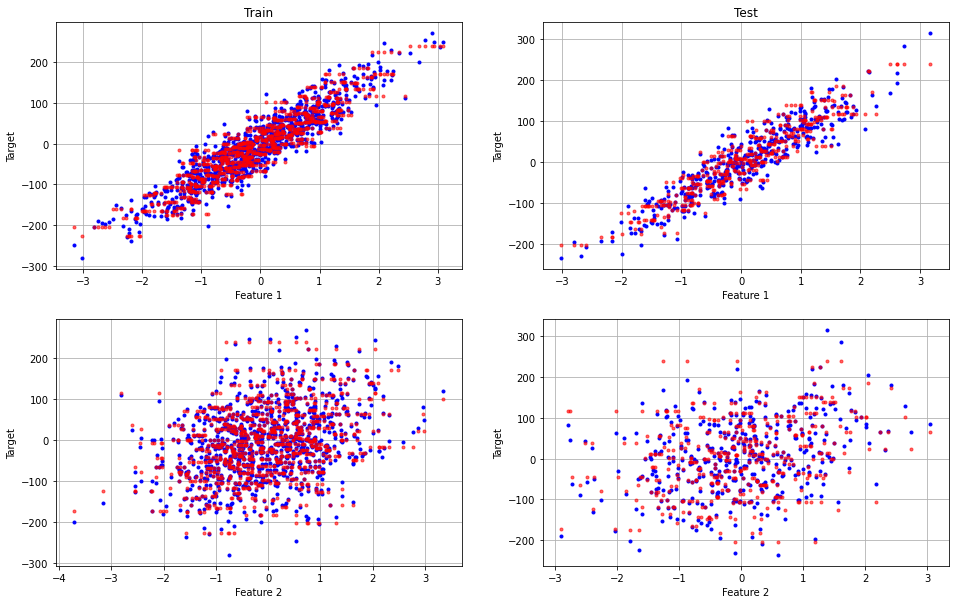

In [30]:
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
plt.plot(train_data[:,0], train_labels, '.b')
plt.plot(train_data[:,0], train_pred, '.r', alpha=0.6)
plt.xlabel('Feature 1')
plt.ylabel('Target')
plt.title('Train')
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(test_data[:,0], test_labels, '.b')
plt.plot(test_data[:,0], test_pred, '.r', alpha=0.6)
plt.xlabel('Feature 1')
plt.ylabel('Target')
plt.title('Test')
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(train_data[:,1], train_labels, '.b')
plt.plot(train_data[:,1], train_pred, '.r', alpha=0.6)
plt.xlabel('Feature 2')
plt.ylabel('Target')
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(test_data[:,1], test_labels, '.b')
plt.plot(test_data[:,1], test_pred, '.r', alpha=0.6)
plt.xlabel('Feature 2')
plt.ylabel('Target')
plt.grid(True)

plt.show()

---